In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

## Data exploration

In [2]:
data_original = pd.read_csv('conversion_data.csv')
data_original.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [3]:
data_original.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


the mean in binary variables can be seen as the ratio--3% conversion.

max age == 123??

In [4]:
data_original[data_original['age'] == 123]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1


In [5]:
data_original.sort_values(by='age', ascending=False).head(10)

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1
265167,US,79,1,Direct,1,0
192644,US,77,0,Direct,4,0
154217,US,73,1,Seo,5,0
208969,US,72,1,Direct,4,0
301366,UK,70,0,Ads,5,0
114485,US,70,1,Ads,9,0
57122,UK,69,1,Direct,4,0
290142,US,69,1,Seo,6,0


In [25]:
data_original['country'].unique()

array(['UK', 'US', 'China', 'Germany'], dtype=object)

I could also use value_counts to see different values.

In [26]:
data_original['source'].unique()

array(['Ads', 'Seo', 'Direct'], dtype=object)

no null values

In [20]:
data_original.groupby('converted').mean()

,age,new_user,total_pages_visited
converted,,,
0,30.703961,0.698382,4.550281
1,26.546765,0.297941,14.553529


Seems to be a clear relationship between total_pages visited and converted. Also new users seem to convert more.

## Data visualization

In [21]:
%matplotlib inline

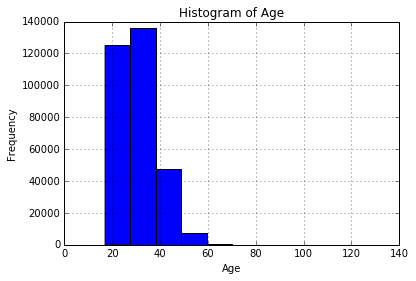

In [22]:
data_original['age'].hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

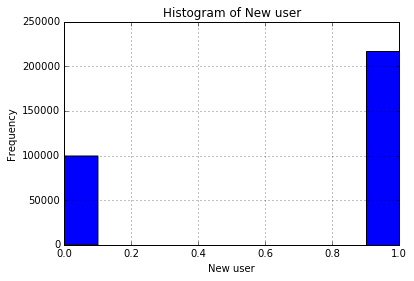

In [23]:
data_original['new_user'].hist()
plt.title('Histogram of New user')
plt.xlabel('New user')
plt.ylabel('Frequency')

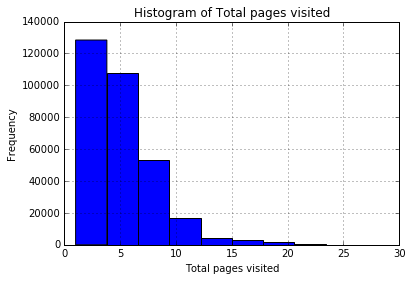

In [24]:
data_original['total_pages_visited'].hist()
plt.title('Histogram of Total pages visited')
plt.xlabel('Total pages visited')
plt.ylabel('Frequency')

## Data preparation

In [27]:
dummy_country = pd.get_dummies(data_original['country'], prefix='country')
dummy_country.head()

,country_China,country_Germany,country_UK,country_US
0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0


In [34]:
dummy_source = pd.get_dummies(data_original['source'], prefix='source')
dummy_source.head()

,source_Ads,source_Direct,source_Seo
0,1.0,0.0,0.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0


In [46]:
data_lr = data_original[['age', 'new_user', 'total_pages_visited', 'converted']].join([dummy_country, dummy_source])
data_lr.head()

,age,new_user,total_pages_visited,converted,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,23,1,5,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,28,1,4,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,39,1,5,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,30,1,6,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


## Logistic regression

In [55]:
X = data_lr[['age', 'new_user', 'total_pages_visited', 'country_China', 'country_Germany', 'country_UK', 'country_US', 'source_Ads', 'source_Direct', 'source_Seo']]
y = data_lr[['converted']]
y = np.ravel(y)

In [56]:
model = LogisticRegression()

In [58]:
model = model.fit(X, y)
model.score(X, y)

0.98617963314358004

In [67]:
pd.DataFrame(dict(zip(X.columns, np.transpose(model.coef_))))

,age,country_China,country_Germany,country_UK,country_US,new_user,source_Ads,source_Direct,source_Seo,total_pages_visited
0,-0.073743,-3.784136,-0.108116,-0.299291,-0.664924,-1.734932,-1.547903,-1.734554,-1.574009,0.755224
